# **Logistic Regression Classifier**

**Google drive login for .csv files**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Python code for the classificator**

In [16]:
import numpy as np
import pandas as pd
import re
from collections import Counter


# Preprocessing Functions
def tokenize(text):
    text = text.lower() # Converts all text to lowercase
    text = re.sub(r'[^a-z\s]', '', text) # Removes punctuation
    return text.split() # Splits the text into a list of words

def build_vocab(texts, max_vocab_size=5000):
    counter = Counter() # Creates an object "Counter" (imported from collections) to count all word occurrencies
    for text in texts:
        tokens = tokenize(text)
        counter.update(tokens)
    vocab = {word: i for i, (word, _) in enumerate(counter.most_common(max_vocab_size))} # Selects max_vocab_size the most frequents words and assigns an index to each one
    return vocab

def vectorize(text, vocab):
    vec = [0] * len(vocab) # Initializes an array of zeros having the dictionary, increments the corresponding position in the vector
    for word in tokenize(text):
        if word in vocab:
            vec[vocab[word]] += 1 # Example: if "fake" is the 10th word inside the dictionary, vec[9] += 1
    return vec


# Logistic Regression Model
class LogisticRegressionClassifier: # Defines a new class which implements a logistic regression model
    def __init__(self, input_dim, lr=0.005, epochs=1000): # Contructor method
        # input_dim: number of input features
        # lr: learning rate (weights)
        # epochs: number of training iterations
        self.w = np.zeros(input_dim) # Initializes the weights "w" as an array of zeros, with a dimension equal to the number of features
        self.b = 0
        self.lr = lr
        self.epochs = epochs
        self.losses = [] # Initializes an empty list used to save the loss function values during training

    def sigmoid(self, z):  # Defines an internal class function to calculate the sigmoid function, which transforms a real value to a value between 0 and 1 (probability)
      z = np.clip(z, -500, 500)  # Limits the values of "z" between -500 and 500 to avoid numerical overflow problems with the exponential (np.exp)
      return 1 / (1 + np.exp(-z)) # Calculate the sigmoid function: 1 / (1 + exp(-z)), which is used to obtain the predicted probabilities from any linear input.

    def predict_prob(self, X): # Method that calculates the probability that input X belongs to class 1.
        return self.sigmoid(np.dot(X, self.w) + self.b) # Calculate the linear combination X*w + b and pass the result to the sigmoid function to obtain the probability.

    def predict(self, X): # Metodo per ottenere le classi predette (0 o 1) da input X.
        return (self.predict_prob(X) >= 0.5).astype(int) # Calcola la probabilità e converte in etichetta 0 o 1 usando soglia 0.5 (se la probabilità è ≥ 0.5 predice 1, altrimenti 0)

    def fit(self, X, y): # Method to train the model using X (input) and y (true labels) data
        for epoch in range(self.epochs): # Training cycle that repeats for epochs times
            y_hat = self.predict_prob(X) # Calculate the probabilities predicted by the model for all X examples.
            error = y_hat - y # Calculate the error as the difference between predicted probabilities and true values (y).

            dw = np.dot(X.T, error) / len(y) # Calculates the gradient of loss versus weights (average of the products between error and input)
            db = np.mean(error) # Calculates the gradient of loss versus bias b (average of errors)

            # Update weights and bias by moving them in the opposite direction of the gradient, the step is modulated by the learning rate lr
            self.w -= self.lr * dw
            self.b -= self.lr * db


            loss = -np.mean(y * np.log(y_hat + 1e-8) + (1 - y) * np.log(1 - y_hat + 1e-8)) # Calculate the cross-entropy, a measure of how wrong the predictions are, the 1e-8 avoids log(0).
            self.losses.append(loss)  # Save loss at each epoch

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")


# Evaluation Function
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


if __name__ == "__main__":

    # Load the datasets Fake.csv and True.csv, adding a label column (0 for fake, 1 for real).
    df_fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake.csv", on_bad_lines='skip')
    df_fake["label"] = 0
    df_real = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/True.csv", on_bad_lines='skip')
    df_real["label"] = 1

    # Serves to merge, randomly mix and re-index
    # sample(frac=1) → Takes a random sample of 100% of the rows, then randomly shuffles all the rows in the merged DataFrame.
    # After shuffling, the index is disordered (ex: [10, 3, 45, ...]), .reset_index(drop=True) resets the index from zero (0, 1, 2, ...) and discards the old one (drop=True).
    data = pd.concat([df_fake, df_real]).sample(frac=1, random_state=42).reset_index(drop=True)

    # data[“text”] → takes the text column from the dataFrame data (i.e., news texts).
    # .fillna(“”) → replaces any NaN (missing) values with an empty string “”, to avoid errors in preprocessing.
    # .tolist() → converts the column (which is a Series) to a list of strings.
    # Result: a texts list containing all news texts.
    texts = data["text"].fillna("").tolist()

    # Extracts the label column, which contains the labels (e.g., 0 for fake, 1 for real).
    # .values converts it to a NumPy array, useful for ML models.
    # Result: an array labels with the labels associated with each text.
    labels = data["label"].values

    # Builds vocabulary from the list of news texts
    vocab = build_vocab(texts, max_vocab_size=3000)
    print(f"Vocabulary size: {len(vocab)}")

    # Cycle over all texts in the texts list and apply the vectorize function to each one.
    # Example:
    # texts = [“fake news”, “real news”, “fake fake”]
    # vectorize(text, vocab)
    # vocab = {‘fake’: 0, ‘real’: 1, ‘news’: 2}
    # texts = [‘fake news’, ‘real news’, ‘fake fake’]
    # Initialize a vector with zeros: [0, 0, 0], then for each word:
    # “fake” is in the vocabulary at position 0 → increment vec[0] += 1 → [1, 0, 0]
    # “news” is at position 2 → increment vec[2] += 1 → [1, 0, 1]
    # vectorize(“fake news,” vocab) → [1, 0, 1]
    # vectorize(“real news,” vocab) → [0, 1, 1]
    # vectorize(“fake fake,” vocab) → [2, 0, 0]
    # X = [[1 0 1]
    # [0 1 1]
    # [2 0 0]]
    X = np.array([vectorize(text, vocab) for text in texts]) # Each row represents a text, each column represents a vocabulary word, the values are the frequencies of the words in the text
    y = np.array(labels) # contains the corresponding labels (0 for fake, 1 for real)

    # Divides the dataset into → Training set: first 80% of the data | Test set: last 20% of the data
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Training of the model
    print("Training")
    model = LogisticRegressionClassifier(input_dim=X.shape[1], lr=0.01, epochs=300)
    model.fit(X_train, y_train)

    # Evaluation of the classification
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy(y_test, y_pred))


Vocabulary size: 3000
Training
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.2240
Epoch 200, Loss: 0.1855
Accuracy: 0.9667037861915367



**Fake vs Real distribution**

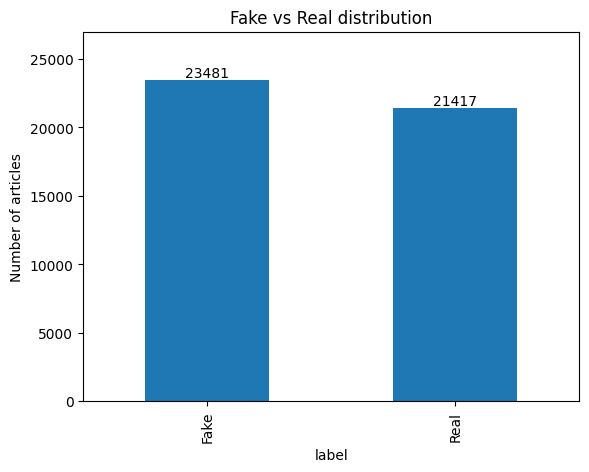

In [17]:
import matplotlib.pyplot as plt

counts = data['label'].value_counts()
ax = data['label'].value_counts().plot(kind='bar')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.ylabel('Number of articles')
plt.title('Fake vs Real distribution')
plt.ylim(0, counts.max() * 1.15)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 200,
            int(height), ha='center')
plt.show()

**Confusion matrix**

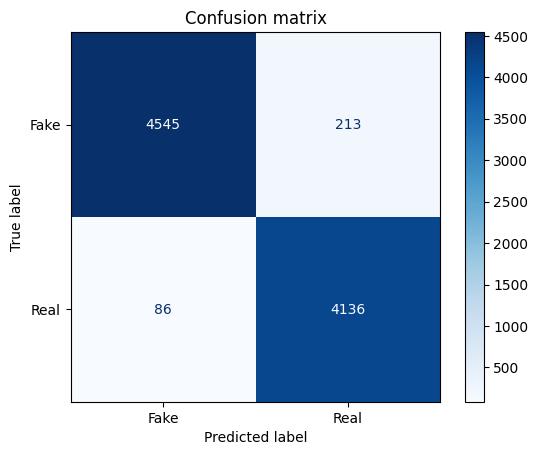

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Fake', 'Real']).plot(cmap='Blues')
plt.title('Confusion matrix')
plt.show()

**Loss trend during training**

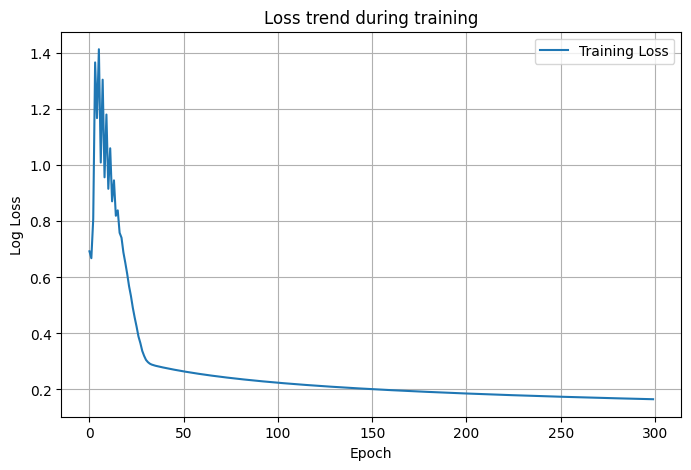

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(len(model.losses)), model.losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Loss trend during training")
plt.legend()
plt.grid(True)
plt.show()